In [1]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')

    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews

    !pip install joypy
    # !pip install umap-learn
    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Results')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Figures')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Result')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics/Jaguas"
    root_path = "media/mirp_ai/Seagate Desktop Drive/Jaguas_2018"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import datetime
import gc
import pandas as pd
import joypy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import random_split

import torchvision.datasets as datasets

from Jaguas_DataLoader_rainless import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datetime import timedelta

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/mirp_ai/anaconda3/envs/DANM/lib/python3.10/site-packages/umap/dist

root_audios = f"{root}/Complementary_Files/Audios_Jaguas/Audios_Jaguas.csv"
root_recorders = f"{root}/Complementary_Files/df_grabadoras_reg.csv"
root_clusters = f"{root}/temporal/clusters"
root_ai = f"{root}/Complementary_Files/Acoustic_Indices/AI_Jaguas.csv"
root_vggish = f"{root}/vggish/Features_vggish"
ecological_integrity = f"{root}/Complementary_Files/Indice_Integridad_Ecologica.xlsx"

audios = pd.read_csv(root_audios, index_col=0)
recorders = pd.read_csv(root_recorders, sep=";")
ei  = pd.read_excel(ecological_integrity)
ai = pd.read_csv(root_ai)
ai.drop(columns=["Unnamed: 0"], inplace=True)
ai.drop(columns=["Date"], inplace=True)
ai.dropna(inplace=True)

ai.set_index("file",inplace=True, drop=True)
audios.set_index("Filename", inplace=True)

In [4]:
df_ae_unflat = pd.read_csv("New_df_ae_unflat.csv")
# df_ae_unflat.set_index("y", inplace=True)
df_ae_unflat

,y,0,1,2,3,4,5,6,7,8,...,5180,5181,5182,5183,y.1,location,day,hour,hour_stage,Habitat
0,G03_20180511_120000.wav,2.836208,2.738645,2.750303,2.949074,2.797478,2.600430,2.634313,2.557798,2.700141,...,0.195821,0.000000,0.275948,0.404869,G03_20180511_120000.wav,G03,11,12,day,Forest
1,G03_20180511_121600.wav,2.553919,2.545453,2.683599,2.611094,2.626767,2.629764,2.620549,2.563438,2.685288,...,1.307478,0.615687,0.746481,1.075634,G03_20180511_121600.wav,G03,11,12,day,Forest
2,G03_20180511_123200.wav,2.566810,2.560687,2.620509,2.585397,2.663058,2.596723,2.596157,2.604591,2.532693,...,0.956451,0.544939,0.664157,0.571270,G03_20180511_123200.wav,G03,11,12,day,Forest
3,G03_20180511_124800.wav,2.579430,2.594648,2.625336,2.622671,2.616172,2.683312,2.683129,2.593217,2.636931,...,2.138691,2.631092,3.193225,2.844346,G03_20180511_124800.wav,G03,11,12,day,Forest
4,G03_20180511_130400.wav,2.616449,2.583424,2.574568,2.603247,2.591041,2.636733,2.596150,2.598920,2.602844,...,0.205902,0.108983,0.258072,0.378485,G03_20180511_130400.wav,G03,11,13,day,Forest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16906,G58_20180704_083200.wav,6.619374,7.024989,6.410773,6.524171,6.750802,6.741341,6.373626,6.715012,6.563634,...,0.000000,0.000000,0.000000,0.000000,G58_20180704_083200.wav,G58,4,8,morning,Forest
16907,G58_20180704_084800.wav,4.230885,4.965734,4.631593,5.015845,5.168448,5.238913,6.166856,6.290795,4.894090,...,0.000000,0.000000,0.000000,0.000000,G58_20180704_084800.wav,G58,4,8,morning,Forest
16908,G58_20180704_090400.wav,1.877826,1.865762,1.851426,1.217864,1.335746,1.137487,1.248162,1.238155,1.297273,...,0.000000,0.000000,0.000000,0.000000,G58_20180704_090400.wav,G58,4,9,day,Forest
16909,G58_20180704_092000.wav,1.634390,1.579617,1.264601,1.272597,1.620857,1.449098,1.033211,1.379931,1.234115,...,0.000000,0.000000,0.000000,0.000000,G58_20180704_092000.wav,G58,4,9,day,Forest


## All classification covers

Accuracy: 0.9216671593260419
f1: 0.8948692014295054
recall 0.8778108705503879
[[0.97141707 0.02858293]
 [0.21579533 0.78420467]]
[[2413   71]
 [ 194  705]]


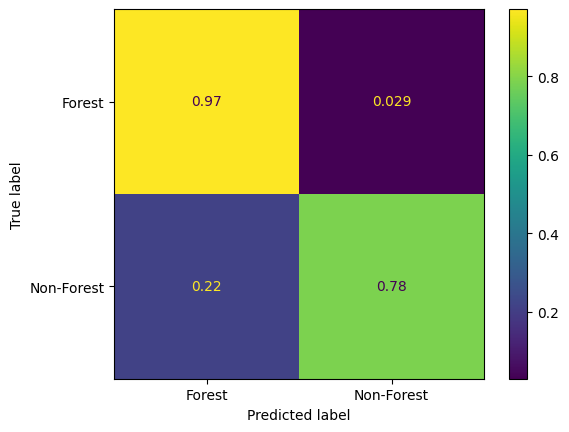

In [16]:
#### from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = np.asarray(df_ae_unflat.iloc[:,0:5184])
y = np.asarray(df_ae_unflat.loc[:,"Habitat"])
# X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5]) # 0.805
# X = np.mean(X,axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
# X_train = np.reshape(X_train, [X_train.shape[0]*5,X_train.shape[2]])
# X_test = np.reshape(X_test, [X_test.shape[0]*5,X_test.shape[2]])
# y_train = np.repeat(y_train,5)
# y_test = np.repeat(y_test,5)
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)


confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_rf, normalize="true")
print(confusion_matrix_norm)
print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_norm, display_labels = ["Forest", "Non-Forest"])
cm_display.plot()
plt.show()

## All classification hours

Accuracy: 0.9092521430682826
f1: 0.8891693053245667
recall 0.8839719707610155
[[0.93371522 0.0507365  0.01554828]
 [0.10542636 0.76899225 0.1255814 ]
 [0.03100264 0.01978892 0.94920844]]
[[1141   62   19]
 [  68  496   81]
 [  47   30 1439]]


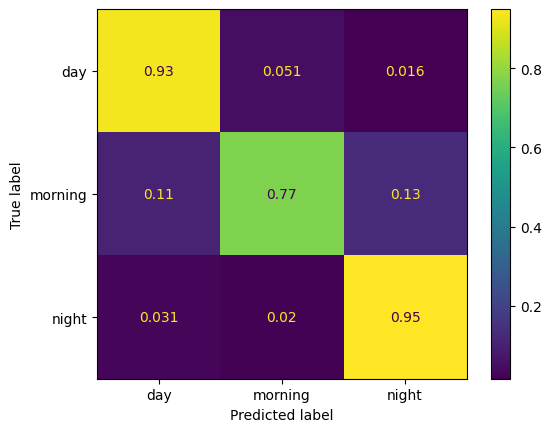

In [20]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

X = np.asarray(df_ae_unflat.iloc[:,0:5184])
y = np.asarray(df_ae_unflat.loc[:,"hour_stage"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
# X_train = np.reshape(X_train, [X_train.shape[0]*5,X_train.shape[2]])
# X_test = np.reshape(X_test, [X_test.shape[0]*5,X_test.shape[2]])
# y_train = np.repeat(y_train,5)
# y_test = np.repeat(y_test,5)
clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_rf)
f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
print("Accuracy:", accuracy)
print("f1:", f1_score)
print("recall", recall)


confusion_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
confusion_matrix_norm = metrics.confusion_matrix(y_test, y_pred_rf, normalize="true")
print(confusion_matrix_norm)
print(confusion_matrix)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_norm, display_labels = ["day", "morning", "night"])
cm_display.plot()
plt.show()


## Cover Classification

In [21]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
accuracies_ae_unflat_covers = []
f1_scores_ae_unflat_covers = []
recalls_ae_unflat_covers = []

df_day={}
days = list(range(1,31))
for i in range(len(days)):
    days[i] = str(days[i])
for i in days:
    df_day = df_ae_unflat[df_ae_unflat['day'].isin([int(i)])]
    X = np.asarray(df_day.iloc[:,0:5184])
    y = np.asarray(df_day.loc[:,"Habitat"])
#     X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
#     X_train = np.reshape(X_train, [X_train.shape[0]*5,X_train.shape[2]])
#     X_test = np.reshape(X_test, [X_test.shape[0]*5,X_test.shape[2]])
#     y_train = np.repeat(y_train,5)
#     y_test = np.repeat(y_test,5)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_ae_unflat_covers.append(accuracy)
    f1_scores_ae_unflat_covers.append(f1_score)
    recalls_ae_unflat_covers.append(recall)
    
np.save(f"{root}/temporal/classification_results/accuracies_ae_unflat_covers.npy", accuracies_ae_unflat_covers)
np.save(f"{root}/temporal/classification_results/f1_scores_ae_unflat_covers.npy", f1_scores_ae_unflat_covers)
np.save(f"{root}/temporal/classification_results/recalls_ae_unflat_covers.npy", recalls_ae_unflat_covers)

Accuracy: 0.9658119658119658
f1: 0.9071428571428571
recall 0.8571428571428572
Accuracy: 0.9809523809523809
f1: 0.9631320224719101
recall 0.9411764705882353
Accuracy: 0.9711538461538461
f1: 0.939895973800809
recall 0.90625
Accuracy: 0.9864864864864865
f1: 0.9667714414009878
recall 0.9444444444444444
Accuracy: 1.0
f1: 1.0
recall 1.0
Accuracy: 1.0
f1: 1.0
recall 1.0
Accuracy: 1.0
f1: 1.0
recall 1.0
Accuracy: 1.0
f1: 1.0
recall 1.0
Accuracy: 1.0
f1: 1.0
recall 1.0
Accuracy: 0.9772727272727273
f1: 0.9575289575289576
recall 0.9333333333333333
Accuracy: 0.99
f1: 0.9890817774866252
recall 0.9861111111111112
Accuracy: 0.9680851063829787
f1: 0.967005967005967
recall 0.9652680652680652
Accuracy: 0.9478260869565217
f1: 0.9456521739130435
recall 0.9456521739130435
Accuracy: 0.9176470588235294
f1: 0.9105128590765529
recall 0.9030070754716981
Accuracy: 0.956989247311828
f1: 0.9561320754716981
recall 0.9537992495309568
Accuracy: 0.972972972972973
f1: 0.970843183609141
recall 0.9734154929577465
Accurac

## Hour Stage Classification

In [24]:
df_day

,0,1,2,3,4,5,6,7,8,9,...,5180,5181,5182,5183,y.1,location,day,hour,hour_stage,Habitat
y,,,,,,,,,,,,,,,,,,,,,
G13_20180601_000000.wav,8.380812,7.598907,7.056699,7.674321,7.265830,8.275502,8.151886,7.322646,7.923404,2.984971,...,3.979809,3.982787,3.980835,3.968810,G13_20180601_000000.wav,G13,1,0,night,Forest
G13_20180601_020800.wav,4.919572,5.490032,5.296108,5.318748,4.287193,5.091517,5.317826,5.710103,5.214522,6.065357,...,3.998132,3.998109,3.998437,3.998221,G13_20180601_020800.wav,G13,1,2,night,Forest
G13_20180601_022400.wav,4.985896,6.032172,5.735356,5.506932,5.279624,5.633826,5.667394,6.266374,5.595554,5.483884,...,3.998524,3.998588,3.998333,3.998323,G13_20180601_022400.wav,G13,1,2,night,Forest
G13_20180601_024000.wav,1.760173,1.851631,2.096297,1.968025,2.210221,2.291958,1.904786,2.519685,1.986517,7.293551,...,3.998766,3.998782,3.998764,3.998835,G13_20180601_024000.wav,G13,1,2,night,Forest
G13_20180601_025600.wav,4.662105,4.486328,4.413835,5.445638,5.188752,5.237150,4.653230,5.347491,5.187047,6.871758,...,3.998785,3.998798,3.998771,3.998725,G13_20180601_025600.wav,G13,1,2,night,Forest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G58_20180701_183000.wav,1.471475,1.468580,1.432970,1.466737,1.331827,1.393873,1.493777,1.599268,1.359150,4.423586,...,3.610829,3.590510,3.825778,3.801041,G58_20180701_183000.wav,G58,1,18,night,Forest
G58_20180701_184500.wav,2.221164,2.858480,2.182259,1.892471,1.913142,1.850239,1.907428,2.441588,2.703601,4.250432,...,3.686334,3.694193,3.701922,3.749831,G58_20180701_184500.wav,G58,1,18,night,Forest
G58_20180701_190000.wav,1.748070,1.777970,1.725400,1.691059,1.760937,1.713957,1.657205,1.781937,1.731927,0.000000,...,3.320247,3.455029,3.495027,3.579787,G58_20180701_190000.wav,G58,1,19,night,Forest


In [28]:
df_ae_unflat

,0,1,2,3,4,5,6,7,8,9,...,5180,5181,5182,5183,y.1,location,day,hour,hour_stage,Habitat
y,,,,,,,,,,,,,,,,,,,,,
G03_20180511_120000.wav,2.836208,2.738645,2.750303,2.949074,2.797478,2.600430,2.634313,2.557798,2.700141,6.923332,...,0.195821,0.000000,0.275948,0.404869,G03_20180511_120000.wav,G03,11,12,day,Forest
G03_20180511_121600.wav,2.553919,2.545453,2.683599,2.611094,2.626767,2.629764,2.620549,2.563438,2.685288,6.894317,...,1.307478,0.615687,0.746481,1.075634,G03_20180511_121600.wav,G03,11,12,day,Forest
G03_20180511_123200.wav,2.566810,2.560687,2.620509,2.585397,2.663058,2.596723,2.596157,2.604591,2.532693,6.931817,...,0.956451,0.544939,0.664157,0.571270,G03_20180511_123200.wav,G03,11,12,day,Forest
G03_20180511_124800.wav,2.579430,2.594648,2.625336,2.622671,2.616172,2.683312,2.683129,2.593217,2.636931,6.906650,...,2.138691,2.631092,3.193225,2.844346,G03_20180511_124800.wav,G03,11,12,day,Forest
G03_20180511_130400.wav,2.616449,2.583424,2.574568,2.603247,2.591041,2.636733,2.596150,2.598920,2.602844,6.889235,...,0.205902,0.108983,0.258072,0.378485,G03_20180511_130400.wav,G03,11,13,day,Forest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G58_20180704_083200.wav,6.619374,7.024989,6.410773,6.524171,6.750802,6.741341,6.373626,6.715012,6.563634,4.850695,...,0.000000,0.000000,0.000000,0.000000,G58_20180704_083200.wav,G58,4,8,morning,Forest
G58_20180704_084800.wav,4.230885,4.965734,4.631593,5.015845,5.168448,5.238913,6.166856,6.290795,4.894090,1.316806,...,0.000000,0.000000,0.000000,0.000000,G58_20180704_084800.wav,G58,4,8,morning,Forest
G58_20180704_090400.wav,1.877826,1.865762,1.851426,1.217864,1.335746,1.137487,1.248162,1.238155,1.297273,0.000000,...,0.000000,0.000000,0.000000,0.000000,G58_20180704_090400.wav,G58,4,9,day,Forest


In [30]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
accuracies_ae_unflat_hours = []
f1_scores_ae_unflat_hours = []
recalls_ae_unflat_hours = []

df_day={}
days = list(range(1,31))
for i in range(len(days)):
    days[i] = str(days[i])
for i in days:
    df_day = df_ae_unflat[df_ae_unflat['day'].isin([int(i)])]
    X = np.asarray(df_day.iloc[:,0:5184])
    y = np.asarray(df_day.loc[:,"hour_stage"])
#     X = np.reshape(X, [X.shape[0], 5, X.shape[1]//5])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
#     X_train = np.reshape(X_train, [X_train.shape[0]*5,X_train.shape[2]])
#     X_test = np.reshape(X_test, [X_test.shape[0]*5,X_test.shape[2]])
#     y_train = np.repeat(y_train,5)
#     y_test = np.repeat(y_test,5)
    clf_rf = RandomForestClassifier(max_depth=32, random_state=0, n_jobs=-1)
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred_rf)
    f1_score = metrics.f1_score(y_test, y_pred_rf, average="macro")
    recall = metrics.recall_score(y_test, y_pred_rf, average="macro")
    print("Accuracy:", accuracy)
    print("f1:", f1_score)
    print("recall", recall)

    accuracies_ae_unflat_hours.append(accuracy)
    f1_scores_ae_unflat_hours.append(f1_score)
    recalls_ae_unflat_hours.append(recall)
    
np.save(f"{root}/temporal/classification_results/accuracies_ae_unflat_hours.npy", accuracies_ae_unflat_hours)
np.save(f"{root}/temporal/classification_results/f1_scores_ae_unflat_hours.npy", f1_scores_ae_unflat_hours)
np.save(f"{root}/temporal/classification_results/recalls_ae_unflat_hours.npy", recalls_ae_unflat_hours)

Accuracy: 0.8632478632478633
f1: 0.837037037037037
recall 0.8388454195907612
Accuracy: 0.9047619047619048
f1: 0.8862110163556215
recall 0.8717667032857285
Accuracy: 0.9134615384615384
f1: 0.8832259731168907
recall 0.8752941176470589
Accuracy: 0.9324324324324325
f1: 0.9251829268292683
recall 0.927536231884058
Accuracy: 0.9692307692307692
f1: 0.9406031069144074
recall 0.9166666666666666
Accuracy: 0.9130434782608695
f1: 0.9049951400279448
recall 0.9069760332599657
Accuracy: 0.9655172413793104
f1: 0.964932546133881
recall 0.9635933806146572
Accuracy: 0.9565217391304348
f1: 0.9527627591836145
recall 0.9586530264279625
Accuracy: 0.9456521739130435
f1: 0.9428464755077659
recall 0.9348583877995643
Accuracy: 0.9659090909090909
f1: 0.947145641882484
recall 0.926241134751773
Accuracy: 0.94
f1: 0.9167810831426392
recall 0.9158730158730158
Accuracy: 0.9361702127659575
f1: 0.911019974177869
recall 0.9250000000000002
Accuracy: 0.8956521739130435
f1: 0.8856469735411382
recall 0.8856682769726248
Accura